In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')  # Add parent directory to the Python path

from LibESN.datasets import lorenz
from LibESN.matrix_generator import matrixGenerator
from LibESN.esn import ESN
from LibESN.esn_fit import ridgeFit
from LibESN.esn_forecast import autonomousForecast

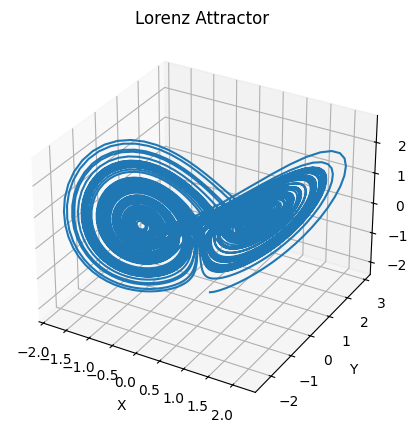

In [3]:
# Example usage
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0
initial_condition = np.array([1, 3, 2])
dt = 0.01
total_time = dt * 10000

# Simulate Lorenz attractor
data = lorenz(sigma, rho, beta, initial_condition, dt, total_time)

# Center and rescale
data = (data - np.mean(data, axis=0)) / 10

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data[:, 0], data[:, 1], data[:, 2])
ax.set_title("Lorenz Attractor")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

In [4]:
N = 100
K = 3

esn = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator(
        (N, N), dist='sparse_normal', sparsity=0.7, 
        normalize='norm2',
        seed=1234
    ), 
    C=matrixGenerator(
        (N, K), dist='sparse_uniform', sparsity=0.7, 
        normalize='norm2',
        seed=12345
    ), 
    zeta=matrixGenerator(
        (N, 1), dist='sparse_normal', sparsity=0.2, 
        normalize='normS',
        seed=123456
    ), 
    rho=0.9, 
    gamma=2, 
    leak=0.1,
)

In [5]:
data_train = data[:8000,]
data_test  = data[8000:,]

ridge = ridgeFit(
    Lambda=1e-6,
)

esn_fit = esn.fit(
    train_data=(data_train, data_train),
    step=1,
    method=ridge,
    burnin=100,
)

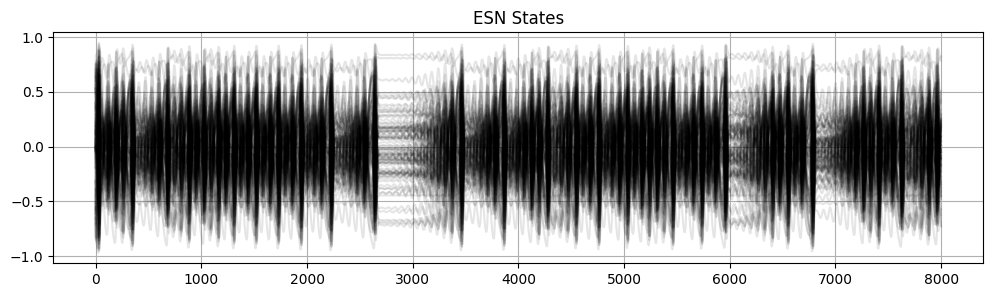

In [6]:
plt.figure(figsize=(12,3))
plt.plot(esn_fit['states'], c='k', alpha=0.1)
plt.grid()
plt.title("ESN States")
plt.show()

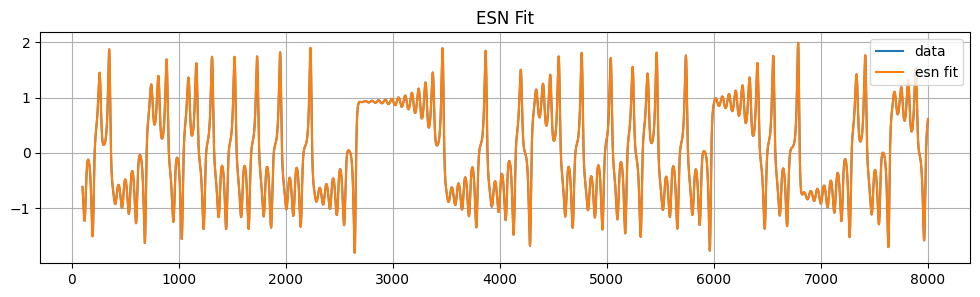

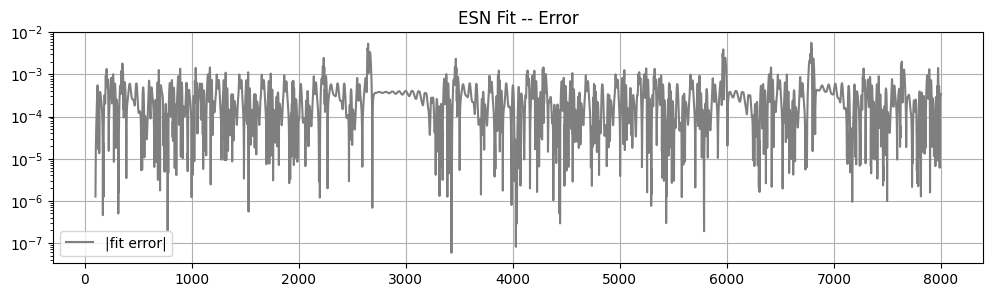

In [7]:
plt.figure(figsize=(12,3))
plt.plot(esn_fit['Y'].iloc[:,0], label="data")
plt.plot(esn_fit['Y_fit'].iloc[:,0], label="esn fit")
plt.grid()
plt.title("ESN Fit")
plt.legend()
plt.show()

plt.figure(figsize=(12,3))
plt.plot(np.abs(esn_fit['residuals'].iloc[:,0]), c='C7', label="|fit error|")
plt.yscale("log")
plt.grid()
plt.title("ESN Fit -- Error")
plt.legend()
plt.show()

In [8]:
auto_esn_for = autonomousForecast(
    esn,
    fit=esn_fit,
    steps=2000
)

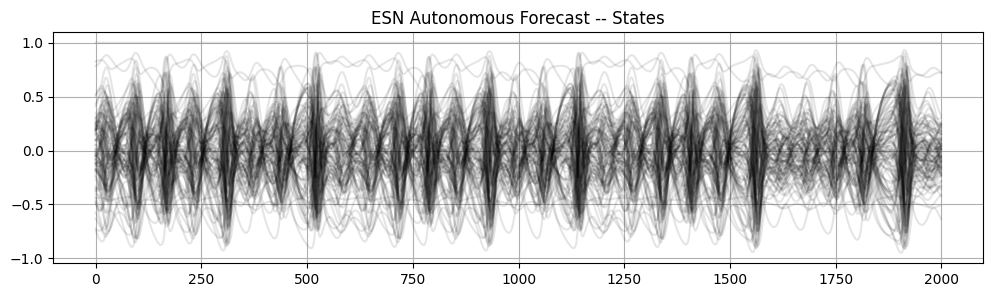

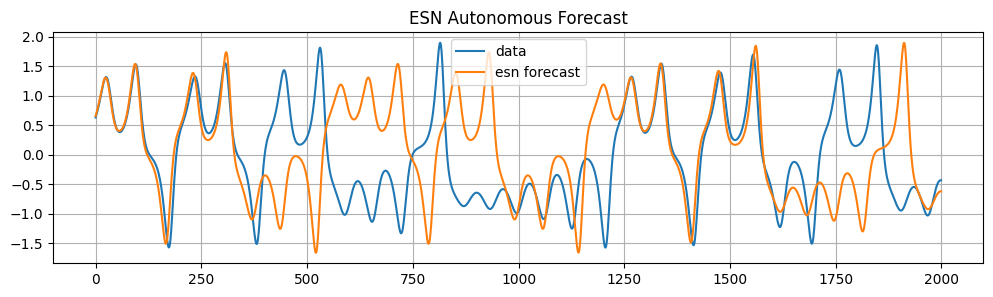

In [9]:
plt.figure(figsize=(12,3))
plt.plot(auto_esn_for['states'], c='k', alpha=0.1)
plt.grid()
plt.title("ESN Autonomous Forecast -- States")
plt.show()

plt.figure(figsize=(12,3))
plt.plot(data_test[:,0], label="data")
plt.plot(auto_esn_for['forecast'][:,0], label="esn forecast")
plt.grid()
plt.title("ESN Autonomous Forecast")
plt.legend()
plt.show()

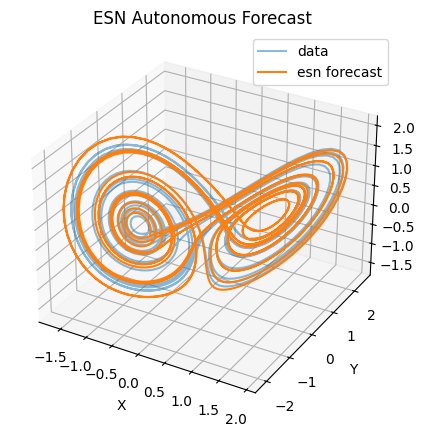

In [10]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data_test[:, 0], data_test[:, 1], data_test[:, 2], alpha=0.5, label="data")
ax.plot(
    auto_esn_for['forecast'][:, 0], 
    auto_esn_for['forecast'][:, 1], 
    auto_esn_for['forecast'][:, 2], 
    label="esn forecast"
)
ax.set_title("ESN Autonomous Forecast")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()